In [2]:
import json
# with open("./outputs/long_corridor/link_data.json", 'r') as f:
#     link_data = json.load(f)
with open("./outputs/spike/link_data.json", 'r') as f:
    link_data = json.load(f)


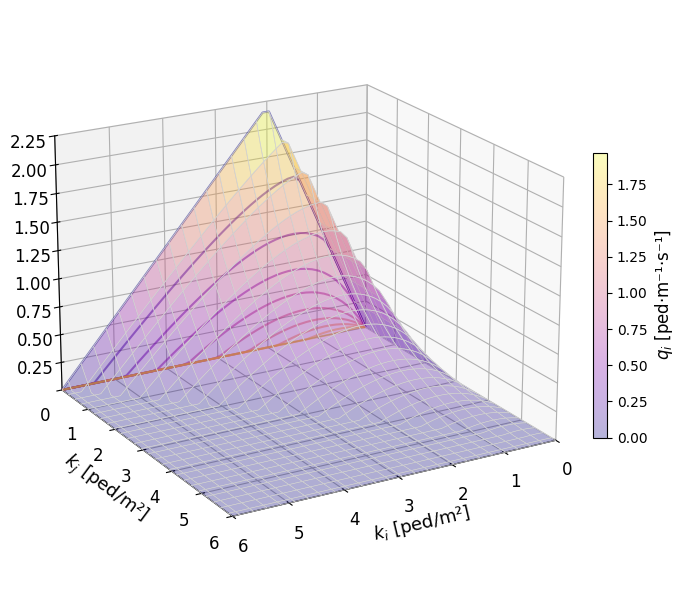

In [6]:
# file: plot_bidirectional_FD_synthetic.py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# ----------------------------------------------------------------------
# 2. Bidirectional FD function
# ----------------------------------------------------------------------
def bi_fd(k1, k2, v_f, k_jam, alpha=1.5, fd_type="greenshields"):
    """
    Bidirectional fundamental diagram
    Returns flow in direction 1 given densities in both directions
    
    Parameters:
    -----------
    k1 : array-like
        Density in direction 1 [ped/m²]
    k2 : array-like  
        Density in direction 2 (opposing direction) [ped/m²]
    v_f : float
        Free-flow speed [m/s]
    k_jam : float
        Jam density [ped/m²]
    alpha : float
        Friction coefficient for opposing flow (>1 means opposing flow is more disruptive)
    
    Returns:
    --------
    q1 : array-like
        Flow in direction 1 [ped·m⁻¹·s⁻¹]
    """
    k_critical = 2.0  # Critical density where congestion starts
    
    # Convert to numpy arrays for vectorized operations
    k1 = np.asarray(k1)
    k2 = np.asarray(k2)
    
    # Calculate effective density (bidirectional interaction)
    k_eff = k1 + alpha * k2
    
    # Initialize speed array
    v = np.zeros_like(k1, dtype=float)
    
    # Free-flow regime: when effective density is below critical
    free_flow_mask = k_eff <= k_critical
    
    # Congested regime: when effective density exceeds critical
    congested_mask = k_eff > k_critical
    
    # Linear speed-density relationship in congested regime
    # v = v_f * (1 - (k_eff - k_critical) / (k_jam - k_critical))
    # Ensures v = v_f at k_critical and v = 0 at k_jam
    v[free_flow_mask] = v_f
    # greenshields
    if fd_type == "greenshields":
        v[congested_mask] = np.maximum(0, 
            -v_f * (k_eff[congested_mask] - k_jam) / (k_jam - k_critical))
    # yperman
    if fd_type == "yperman":
        v[congested_mask] = np.maximum(0, (k_critical * v_f) / (k_jam - k_critical)*(k_jam / k_eff[congested_mask]-1))
    elif fd_type == "smulders":
    # smulders
        v[free_flow_mask] = v_f * (1 - k_eff[free_flow_mask] / k_jam)
        v[congested_mask] = np.maximum(0, v_f*k_critical * (1 / k_eff[congested_mask] - 1 / k_jam))
    # Calculate flow: q = k * v
    q1 = k1 * v
    
    return q1

# ----------------------------------------------------------------------
# 3. Generate data and create 3D plot
# ----------------------------------------------------------------------
k1 = np.array(link_data["1-3"]["density"])
k2 = np.array(link_data["3-1"]["density"])
v1 = np.array(link_data["1-3"]["speed"])
v2 = np.array(link_data["3-1"]["speed"])
q1 = np.array(link_data["1-3"]["link_flow"])

v_f = 1.1
k_jam = 6
alpha = 1

# Create figure
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot simulated data points
# scatter = ax.scatter(k1, k2, q1, c=q1, cmap='viridis', s=30, alpha=0.8,
#                     label='Simulated data', edgecolors='black', linewidth=0.3)

# Create theoretical surface
k_range = np.linspace(0, k_jam, 50)
K1, K2 = np.meshgrid(k_range, k_range)
Q_theory = bi_fd(K1, K2, v_f=v_f, k_jam=k_jam, alpha=alpha, fd_type="yperman")

# Plot theoretical surface
surf = ax.plot_surface(K1, K2, Q_theory,
                      cmap='plasma', alpha=0.3, linewidth=0.5,
                      edgecolors='lightgray', rcount=25, ccount=25,
                      antialiased=True)

# # Add contour lines on the bottom
# contours = ax.contour(K1, K2, Q_theory, zdir='z', offset=0, 
#                      cmap='plasma', alpha=0.5, levels=10)

# Add controur lines on side
# contours = ax.contour(K1, K2, Q_theory, zdir='x', offset=0, 
#                      cmap='plasma', alpha=0.5, levels=10)
contours = ax.contour(K1, K2, Q_theory, zdir='y', offset=0, 
                     cmap='plasma', alpha=0.5, levels=10)

# Formatting
ax.set_xlabel(r'$k_i$ [ped/m²]', fontsize=13)
ax.set_ylabel(r'$k_j$ [ped/m²]', fontsize=13)
# ax.set_zlabel(r'$q_1$ [ped·m⁻¹·s⁻¹]', fontsize=12)

title = f'Bidirectional Pedestrian Flow\n'
title += f'$v_f$ = {v_f:.2f} m/s, $k_{{jam}}$ = {k_jam:.1f} ped/m², $α$ = {alpha:.1f}'
# ax.set_title(title, fontsize=14, pad=20)

# Add colorbar
# cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20)
cbar = plt.colorbar(surf, ax=ax, shrink=0.5, aspect=20, pad=0.01)
cbar.set_label(r'$q_i$ [ped·m⁻¹·s⁻¹]', fontsize=12)

# Set viewing angle for better visualization
ax.view_init(elev=20, azim=60)
# ax.view_init(elev=20, azim=220)

# Add grid
ax.grid(True, alpha=0.3)

# Set axis limits
ax.set_xlim(0, k_jam)
ax.set_ylim(0, k_jam)
ax.set_zlim(0, None)

#tick size
ax.tick_params(axis='both', which='major', labelsize=12)
# Hide the first tick of the z axis
z_ticks = ax.get_zticks()
if len(z_ticks) > 1:
    ax.set_zticks(z_ticks[1:])
# x_ticks = ax.get_xticks()
# ax.set_xticks(x_ticks[:-1])


plt.tight_layout()
plt.show()

# save figure as pdf
fig.savefig('fig/bidirectional_fd_yperman.pdf', bbox_inches='tight')


SYNTHETIC DATA STATISTICS
Generated 1200 data points
Parameters used:
  Free-flow speed (v_f): 1.10 m/s
  Jam density (k_jam): 6.0 ped/m²
  Friction coefficient (α): 1.0

Density ranges:
  Forward (k1): 0.00 - 4.03 ped/m²
  Reverse (k2): 0.00 - 0.95 ped/m²

Flow range:
  Forward (q1): 0.000 - 2.462 ped·m⁻¹·s⁻¹
  Mean flow: 1.824 ped·m⁻¹·s⁻¹


/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_2512/2818438012.py:56: RuntimeWarning: invalid value encountered in divide
  scatter4 = ax4.scatter(total_density, speed, c=k1/(k1+alpha*k2), cmap='RdBu', alpha=0.7)


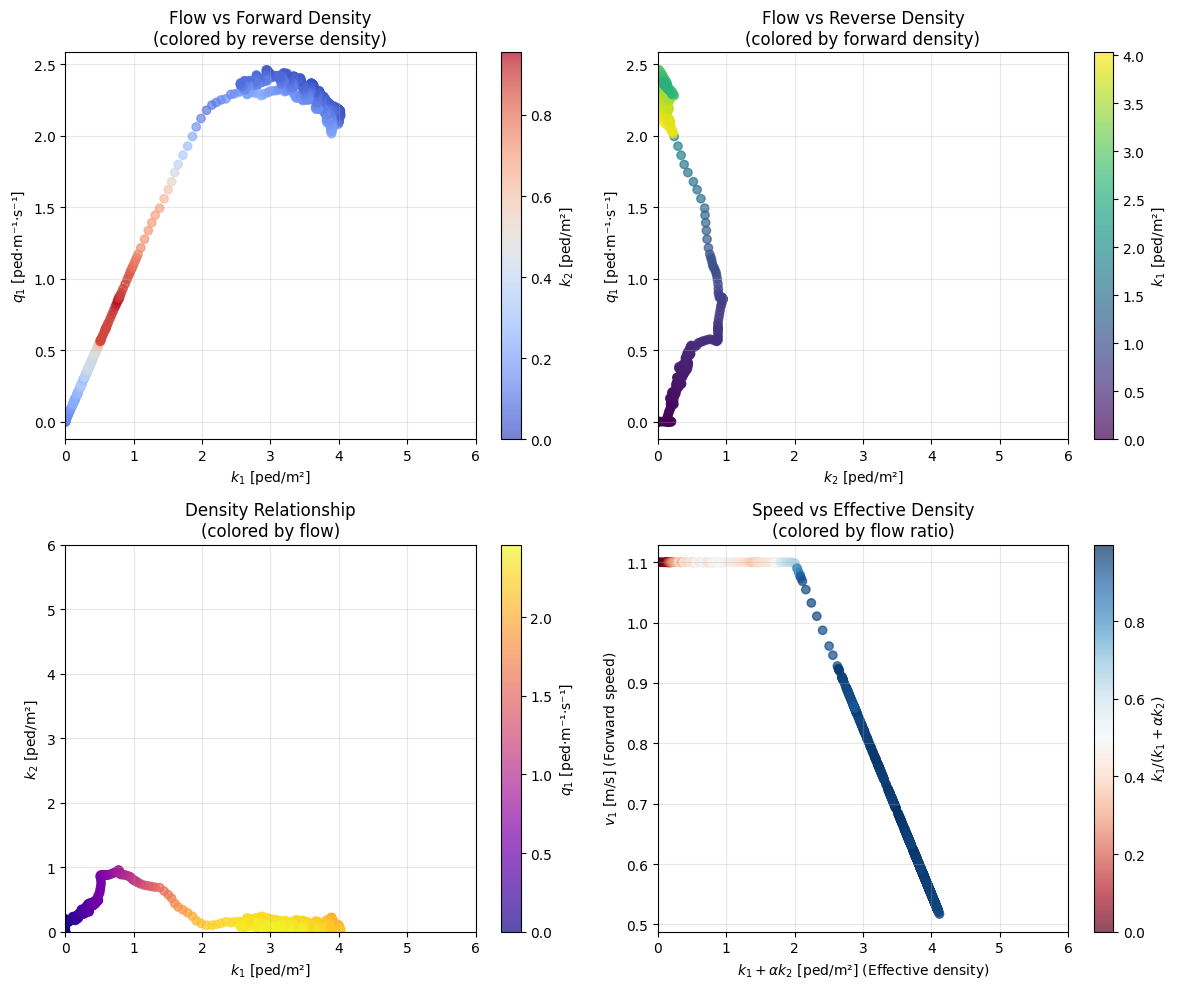

In [86]:
# ----------------------------------------------------------------------
# 4. Print some statistics
# ----------------------------------------------------------------------
print("\n" + "="*50)
print("SYNTHETIC DATA STATISTICS")
print("="*50)
print(f"Generated {len(k1)} data points")
print(f"Parameters used:")
print(f"  Free-flow speed (v_f): {v_f:.2f} m/s")
print(f"  Jam density (k_jam): {k_jam:.1f} ped/m²")
print(f"  Friction coefficient (α): {alpha:.1f}")
print(f"\nDensity ranges:")
print(f"  Forward (k1): {k1.min():.2f} - {k1.max():.2f} ped/m²")
print(f"  Reverse (k2): {k2.min():.2f} - {k2.max():.2f} ped/m²")
print(f"\nFlow range:")
print(f"  Forward (q1): {q1.min():.3f} - {q1.max():.3f} ped·m⁻¹·s⁻¹")
print(f"  Mean flow: {q1.mean():.3f} ped·m⁻¹·s⁻¹")

# ----------------------------------------------------------------------
# 5. Additional 2D projections for better understanding
# ----------------------------------------------------------------------
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# q1 vs k1 (traditional FD, colored by k2)
scatter1 = ax1.scatter(k1, q1, c=k2, cmap='coolwarm', alpha=0.7)
ax1.set_xlabel(r'$k_1$ [ped/m²]')
ax1.set_ylabel(r'$q_1$ [ped·m⁻¹·s⁻¹]')
ax1.set_xlim(0, k_jam)
ax1.set_title('Flow vs Forward Density\n(colored by reverse density)')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label=r'$k_2$ [ped/m²]')

# q1 vs k2 (effect of reverse flow)
scatter2 = ax2.scatter(k2, q1, c=k1, cmap='viridis', alpha=0.7)
ax2.set_xlabel(r'$k_2$ [ped/m²]')
ax2.set_ylabel(r'$q_1$ [ped·m⁻¹·s⁻¹]')
ax2.set_xlim(0, k_jam)
ax2.set_title('Flow vs Reverse Density\n(colored by forward density)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label=r'$k_1$ [ped/m²]')

# k1 vs k2 density relationship
scatter3 = ax3.scatter(k1, k2, c=q1, cmap='plasma', alpha=0.7)
ax3.set_xlabel(r'$k_1$ [ped/m²]')
ax3.set_ylabel(r'$k_2$ [ped/m²]')
ax3.set_xlim(0, k_jam)
ax3.set_ylim(0, k_jam)
ax3.set_title('Density Relationship\n(colored by flow)')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label=r'$q_1$ [ped·m⁻¹·s⁻¹]')

# Speed vs total density
total_density = k1 + alpha * k2
# speed = q1 / np.maximum(k1, 0.001)  # avoid division by zero
speed = v1
scatter4 = ax4.scatter(total_density, speed, c=k1/(k1+alpha*k2), cmap='RdBu', alpha=0.7)
ax4.set_xlabel(r'$k_1 + α k_2$ [ped/m²] (Effective density)')
ax4.set_ylabel(r'$v_1$ [m/s] (Forward speed)')
ax4.set_title('Speed vs Effective Density\n(colored by flow ratio)')
ax4.set_xlim(0, k_jam)
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=ax4, label=r'$k_1 / (k_1 + α k_2)$')

plt.tight_layout()
plt.show()

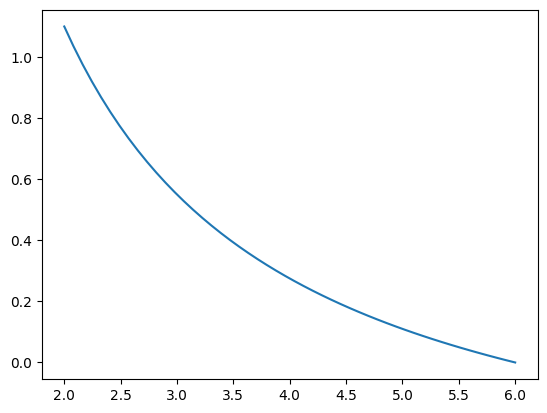

In [15]:
k_c = 2
v_f = 1.1
k_j = 6
theta = 1.13
gamma = 0.545
k = np.linspace(k_c, 6)
v = (k_c*v_f)/(k_j-k_c)*(k_j/k - 1)
# v = 1.5*k_c * (1 / k - 1 / k_j)
# q = v_f * (k_c *k_j)/(k_j - k_c)*(1 - k/k_j)
# k = np.linspace(0, 5.9)
# v = v_f * np.exp(-(k / theta)**gamma)
plt.plot(k, v)